<a href="https://colab.research.google.com/github/preetamjumech/autoencoder_from_scratch/blob/main/Preetam_Saha_29_08_2022_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/kaggle"

In [2]:
!kaggle datasets list -s "greyscale"

ref                                                        title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hal1001k/greyscale-image                                   Greyscale Image                                      11KB  2020-04-09 14:23:03             19          3  0.5              
nageshsingh/fvc2002-fingerprints                           FVC2002 fingerprints                                 26MB  2021-01-14 16:17:02            404         18  0.4375           
ang3loliveira/malware-analysis-datasets-raw-pe-as-image    Malware Analysis Datasets: Raw PE as Image           56MB  2019-08-15 11:57:11            433         16  0.64705884       
sqimeng/gtsrbgreyscale2k                                   GTSRB-greyscale-2k        

In [4]:
!kaggle datasets download -d "sqimeng/gtsrbgreyscale2k"

 86% 95.0M/110M [00:00<00:00, 143MB/s]
100% 110M/110M [00:00<00:00, 147MB/s] 


In [ ]:
!unzip "/content/gtsrbgreyscale2k.zip"

In [8]:
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

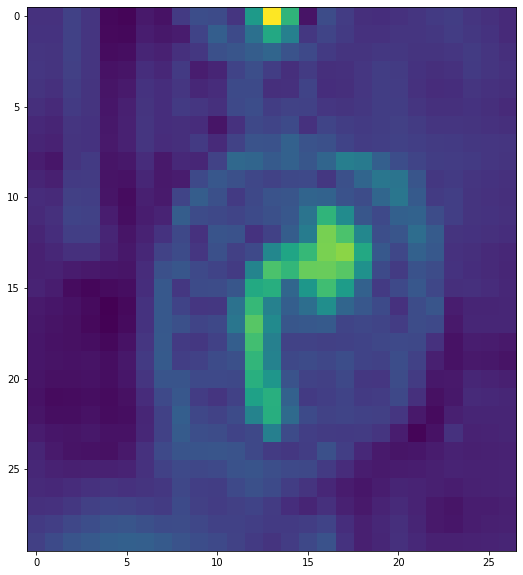

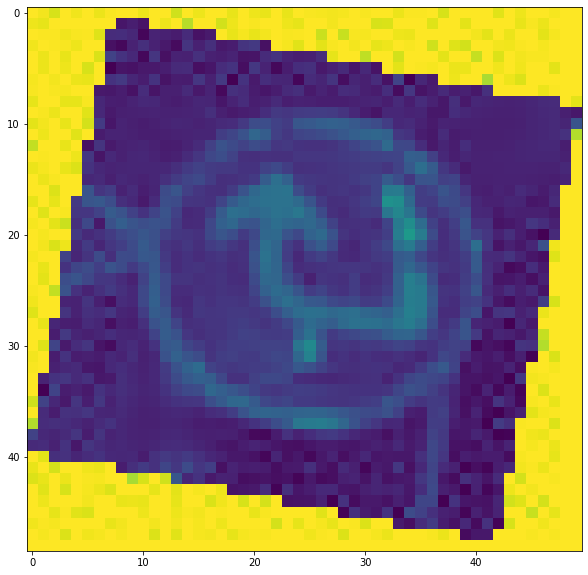

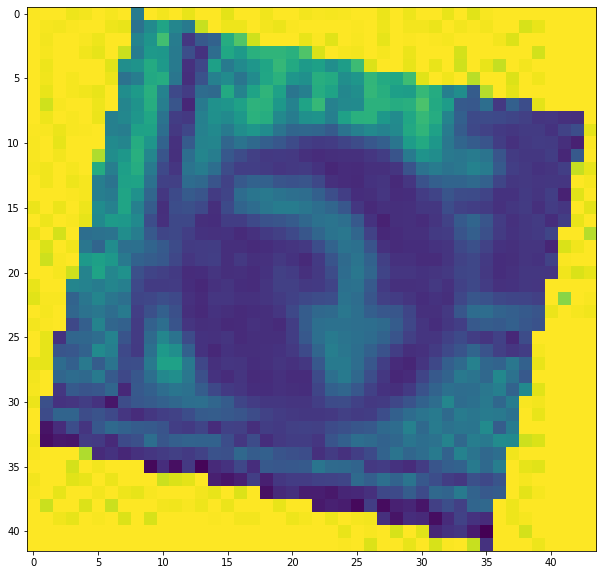

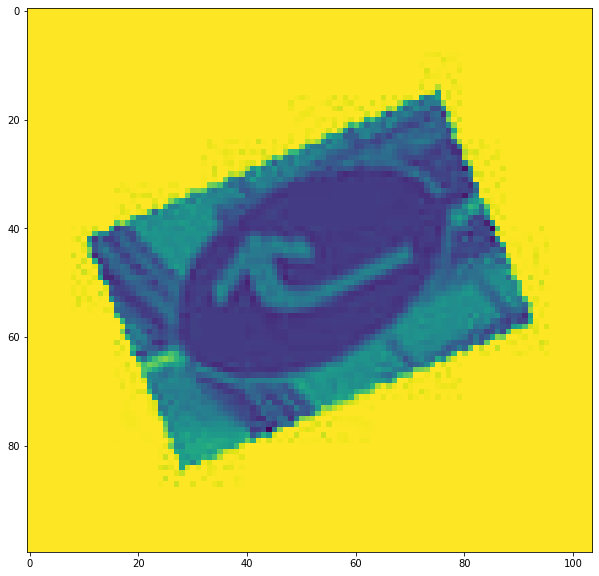

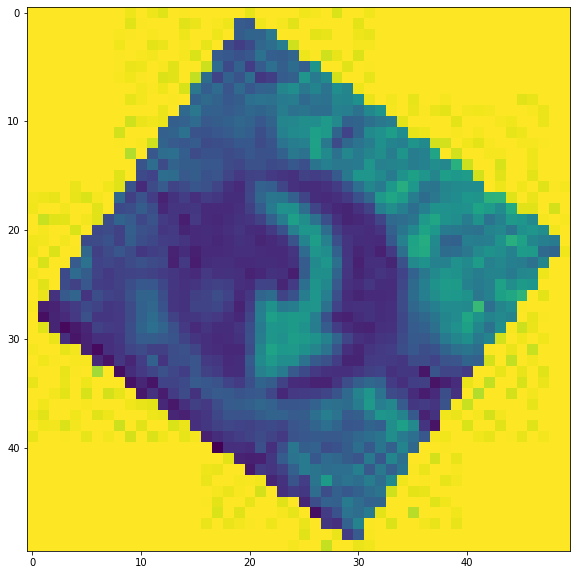

In [9]:
for i in os.listdir("/content/processed_train_data/00033")[20:25]:
  plt.figure()
  a=Image.open(f"/content/processed_train_data/00033/{i}")
  plt.imshow(a)

In [10]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [11]:
transf = transforms.Compose([transforms.PILToTensor(), 
                             transforms.Resize(size=(256,256)),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip()])

In [12]:
np.random.seed(0)
img_index = np.array(range(len(os.listdir('/content/processed_train_data/00033'))))
np.random.shuffle(img_index)

In [13]:
len(img_index)

2000

In [14]:
image_train = np.array(os.listdir('/content/processed_train_data/00033'))[img_index][:1600]
image_train

array(['464.JPEG', '623.JPEG', '1891.JPEG', ..., '1734.JPEG', '407.JPEG',
       '1686.JPEG'], dtype='<U9')

In [17]:
len(image_train)

1600

In [ ]:
image_val = np.array(os.listdir('/content/processed_train_data/00033'))[img_index][1600:]
image_val

In [16]:
len(image_val)

400

In [19]:
image_train.shape

(1600,)

In [23]:
try:
  os.makedirs("Train")
  os.makedirs("Train/img")
except:
  pass

In [24]:
try:
  os.makedirs("Val")
  os.makedirs("Val/img")
except:
  pass

In [25]:
import shutil

In [27]:
for file in image_train:
  shutil.copy('/content/processed_train_data/00033/'+file, 'Train/img/'+file)

In [28]:
for file in image_val:
  shutil.copy('/content/processed_train_data/00033/'+file, 'Val/img/'+file)

In [29]:
len(os.listdir("Train/img"))

1600

In [30]:
len(os.listdir("Val/img"))

400

In [ ]:
os.listdir("Train/img")

In [32]:
train_loader = DataLoader(ImageFolder("Train",transform = transf),batch_size=32,shuffle=True)

In [33]:
val_loader = DataLoader(ImageFolder("Val",transform = transf),batch_size=32,shuffle=True)

In [34]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [35]:
len(train_loader)

50

In [40]:
len(val_loader)

13

In [38]:
for c in train_loader:
  i=c
  break

In [39]:
for d in val_loader:
  j=d
  break

In [41]:
d[0].shape

torch.Size([32, 3, 256, 256])

In [42]:
d[0][1].shape

torch.Size([3, 256, 256])

In [ ]:
img_enc = i[0].reshape(-1,3*256*256)/255
img_enc

In [44]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [45]:
encoder=nn.Sequential(nn.Linear(in_features=3*256*256,out_features=256),nn.ReLU(),
                      nn.Linear(in_features=256,out_features=128),nn.ReLU(),
                      nn.Linear(in_features=128,out_features=64),nn.ReLU(),
                      nn.Linear(in_features=64,out_features=16))

In [46]:
decoder=nn.Sequential(nn.Linear(in_features=16,out_features=64),nn.ReLU(),
                      nn.Linear(in_features=64,out_features=128),nn.ReLU(),
                      nn.Linear(in_features=128,out_features=256),nn.ReLU(),
                      nn.Linear(in_features=256,out_features=3*256*256))

In [47]:
autoencoder=nn.Sequential(encoder,decoder)

In [48]:
train_loader_auto=DataLoader(TensorDataset(img_enc.float()),batch_size=5,shuffle=True)

In [49]:
val_loader_auto=DataLoader(TensorDataset(img_enc.float()),batch_size=5,shuffle=True)

In [50]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [51]:
epochs=10
autoencoder = autoencoder.to(device)
opt = Adam(autoencoder.parameters())

In [52]:
def training(model,train_loader,opt,epoch):
  training_loss = 0.0

#training portion
  for batch in train_loader: #not building any classification model, so input = ouput
    batch = batch[0]
    batch = batch.to(device)
    target = batch.to(device)

    opt.zero_grad()
    train_output = model(batch)
    train_loss = F.mse_loss(train_output,target)
    train_loss.backward()
    opt.step()
    training_loss += train_loss.item()

  if (epoch+1) %  2 ==0:
    print(f"Train loss: {training_loss}")

  return (training_loss)

In [53]:
losses=[]
for epoch in range(epochs):
  losses.append(training(model=autoencoder,train_loader=train_loader_auto,opt=opt,epoch=epoch))

Train loss: 0.5424995385110378
Train loss: 0.3732447810471058
Train loss: 0.3516390770673752
Train loss: 0.3325699754059315
Train loss: 0.2567035723477602


In [54]:
idx = 20
img_arbit = d[0][idx]

In [55]:
img_arbit.shape

torch.Size([3, 256, 256])

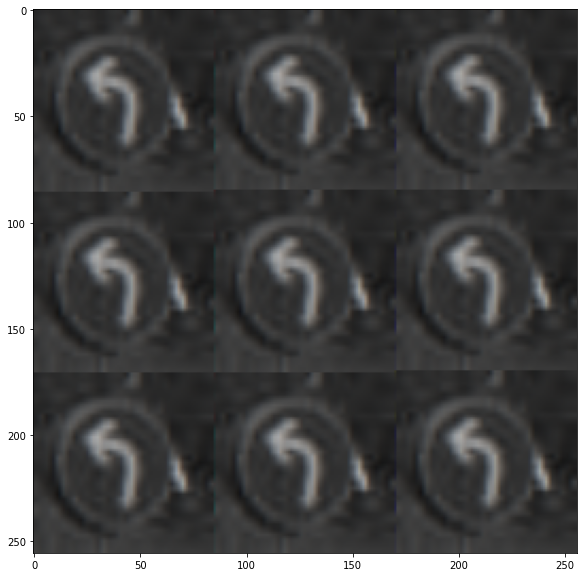

In [59]:
plt.imshow(img_arbit.numpy().reshape(256,256,3))

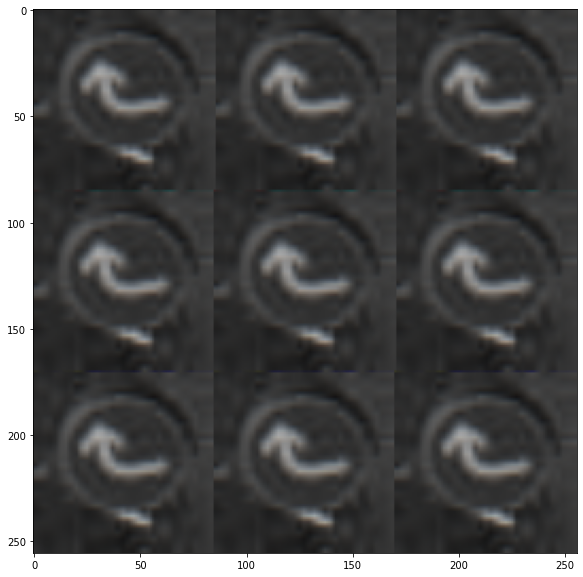

In [61]:
plt.imshow(img_arbit.numpy().reshape(256,256,3).transpose(1,0,2))